In [2]:
import pandas as pd
import numpy as np
import re
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib

nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
with open("synthetic_dataset_with_notes.json", "r") as file:
    data = json.load(file)

df = pd.DataFrame(data)

# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['processed_note'] = df['note'].apply(preprocess_text)

2024-04-30 11:12:35.353091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayesharahman1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ayesharahman1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Validation

No missing values found.
Removed 0 duplicate rows. Remaining rows: 5000
Text preprocessing completed.
Removed 0 entries due to empty or very short processed texts.
Label distribution:
 label
1    0.5006
0    0.4994
Name: proportion, dtype: float64
Text length analysis complete.


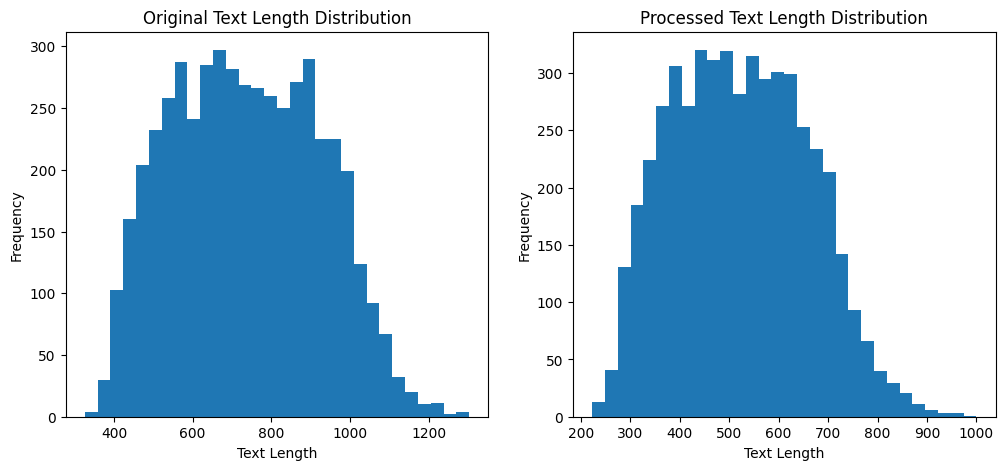

Lower Bound for text length: 312.0
Upper Bound for text length: 746.0
Identified 497 outliers based on text length.
Spell correction applied.
Non-English entries removed, remaining entries: 5000.
Sentiment analysis completed.


.

Sample tokenized sequence: [28, 32, 13, 64, 112, 214, 2, 4, 91, 852, 114, 113, 853, 785, 436, 854, 375, 855, 856, 125, 175, 215, 1912, 753, 288, 655, 1722, 207, 453, 23, 547, 559, 35, 26, 8, 103, 119, 141, 24, 164, 79, 23, 104, 273, 132, 179, 598, 1580, 765, 825, 430, 384, 408, 134, 35, 26, 8, 85, 162, 45, 240, 18, 73, 67, 27, 42, 59, 1, 283, 306, 19, 11, 98, 3, 404, 115, 66, 180, 180, 180, 262, 180, 180, 180, 436, 180, 180, 180, 991, 35, 26, 8, 80, 69, 1, 332, 333, 79, 23, 104, 27, 42, 84, 5, 143, 293, 105, 21]
Number of unique tokens in tokenizer's word index: 2373



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [3]:
import pandas as pd
import numpy as np
import re
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from spellchecker import SpellChecker
from langdetect import detect
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter
import unittest

# Check for missing values
if df.isnull().sum().sum() > 0:
    raise ValueError("Dataset contains missing values.")
else:
    print("No missing values found.")

# Remove duplicate rows
initial_count = len(df)
df.drop_duplicates(inplace=True)
print(f"Removed {initial_count - len(df)} duplicate rows. Remaining rows: {len(df)}")

# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['processed_note'] = df['note'].apply(preprocess_text)
print("Text preprocessing completed.")

# Check for empty or very short processed texts
initial_len = len(df)
df = df[df['processed_note'].str.len() > 1]  # Adjust the length criteria as needed
print(f"Removed {initial_len - len(df)} entries due to empty or very short processed texts.")

# Ensure label distribution is not severely imbalanced
label_distribution = df['label'].value_counts(normalize=True)
print("Label distribution:\n", label_distribution)

# Analyze text length distribution
original_text_lengths = df['note'].apply(len)
processed_text_lengths = df['processed_note'].apply(len)
print("Text length analysis complete.")

# Visualize text length distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(original_text_lengths, bins=30)
plt.title('Original Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(processed_text_lengths, bins=30)
plt.title('Processed Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Calculate lower and upper bounds as the 5th and 95th percentiles of processed text lengths
lower_bound = np.percentile(processed_text_lengths, 5)
upper_bound = np.percentile(processed_text_lengths, 95)

print(f"Lower Bound for text length: {lower_bound}")
print(f"Upper Bound for text length: {upper_bound}")

# Identifying outliers in processed text lengths
outliers = df[(processed_text_lengths < lower_bound) | (processed_text_lengths > upper_bound)]
print(f"Identified {len(outliers)} outliers based on text length.")

# Advanced text cleaning
spell = SpellChecker()

def correct_spelling(text):
    corrected_text = []
    words = text.split()
    for word in words:
        corrected_word = spell.correction(word)
        if corrected_word:
            corrected_text.append(corrected_word)
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

df['processed_note'] = df['processed_note'].apply(correct_spelling)
print("Spell correction applied.")

from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Language Detection
df = df[df['processed_note'].apply(is_english)]
print(f"Non-English entries removed, remaining entries: {len(df)}.")

# Sentiment analysis
df['sentiment'] = df['processed_note'].apply(lambda x: TextBlob(x).sentiment.polarity)
print("Sentiment analysis completed.")


from tensorflow.keras.preprocessing.text import Tokenizer

# Assume want to keep the top 5000 words
max_words = 5000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['processed_note'])

sequences = tokenizer.texts_to_sequences(df['processed_note'])
# In-depth Tokenization analysis
# Assuming 'sequences' and 'tokenizer' are defined from previous tokenization steps
print(f"Sample tokenized sequence: {sequences[0]}")
print(f"Number of unique tokens in tokenizer's word index: {len(tokenizer.word_index)}")

class TestDataProcessing(unittest.TestCase):
    
    def test_preprocess_text(self):
        # Add your test cases here
        pass

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)



In [5]:
# Model Input Analysis

import pandas as pd
import numpy as np
import re
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Model Input Analysis - Loading GloVe Embeddings
print("Loading GloVe embeddings...")

# Initialize an empty dictionary to store GloVe word vectors
embeddings_index = {}

# Specify the path to your GloVe file
GLOVE_PATH = 'glove.42B.300d.txt'  # Adjust path as needed

# Open the GloVe file and populate the 'embeddings_index' dictionary
# Each line in the GloVe file represents a word and its embedding vector
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()  # Split the line into word and vector components
        word = values[0]  # The first entry is the word
        coefs = np.asarray(values[1:], dtype='float32')  # The rest are coefficients (vector)
        embeddings_index[word] = coefs  # Add to the dictionary

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

# Define a function to check embedding coverage of a given text
def check_embedding_coverage(text):
    covered = 0  # Count of words found in GloVe
    oov = 0  # Count of Out-Of-Vocabulary words not found in GloVe
    words = text.split()  # Split the text into individual words
    for word in words:
        if word in embeddings_index:  # Check if the word is in GloVe embeddings
            covered += 1
        else:
            oov += 1
    return covered, oov

# Apply the 'check_embedding_coverage' function to each processed note
df['embedding_coverage'] = df['processed_note'].apply(check_embedding_coverage)

# Print sample embedding coverage results
print("Sample embedding coverage results:")
print(df['embedding_coverage'].sample(5))

# Calculate overall embedding coverage
total_covered = 0
total_oov = 0
for covered, oov in df['embedding_coverage']:
    total_covered += covered
    total_oov += oov

print(f"Total words covered by GloVe embeddings: {total_covered}")
print(f"Total Out-Of-Vocabulary words: {total_oov}")
print(f"Coverage percentage: {100 * total_covered / (total_covered + total_oov):.2f}%")

Loading GloVe embeddings...
Loaded 1917494 word vectors from GloVe.
Sample embedding coverage results:
842     (68, 0)
2968    (54, 0)
4154    (67, 0)
2507    (60, 0)
718     (74, 0)
Name: embedding_coverage, dtype: object
Total words covered by GloVe embeddings: 337768
Total Out-Of-Vocabulary words: 0
Coverage percentage: 100.00%


# Model Training and Testing

In [6]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['processed_note'])
sequences = tokenizer.texts_to_sequences(df['processed_note'])
X = pad_sequences(sequences, maxlen=100)
y = df['label'].values

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Definition
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Evaluation
predictions = model.predict(X_test)
binary_predictions = [1 if p > 0.5 else 0 for p in predictions.flatten()]

# Evaluation Metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, binary_predictions, average='binary')
roc_auc = roc_auc_score(y_test, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Save the model
joblib.dump(model, 'autism_classifier.joblib')

# Save the vectorizer
joblib.dump(tokenizer, 'tfidf_vectorizer.joblib')


2024-04-30 11:25:47.382494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
50/50 [==============================] - 15s 240ms/step - loss: 0.4264 - accuracy: 0.8637 - val_loss: 0.0906 - val_accuracy: 0.9825
Epoch 2/20
50/50 [==============================] - 11s 212ms/step - loss: 0.0277 - accuracy: 0.9947 - val_loss: 0.0092 - val_accuracy: 0.9975
Epoch 3/20
50/50 [==============================] - 8s 163ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 0.9950
Epoch 4/20
50/50 [==============================] - 8s 168ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/20
50/50 [==============================] - 9s 179ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 6/20
50/50 [==============================] - 9s 177ms/step - loss: 8.3682e-04 - accuracy: 1.0000 - val_loss: 8.5112e-04 - val_accuracy: 1.0000
Epoch 7/20
50/50 [==============================] - 9s 185ms/step - loss: 5.4947e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy:

['tfidf_vectorizer.joblib']

# K-fold cross-validation

In [7]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X and y are your data and labels respectively
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Capture performance metrics for each fold
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []

fold_no = 1
for train, test in kfold.split(X, y):
    # Define the model architecture
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=X.shape[1]),
        SpatialDropout1D(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = model.fit(X[train], y[train],
                        batch_size=64,
                        epochs=20,
                        verbose=2,
                        validation_split=0.2,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
    
    # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Additional metrics
    predictions = (model.predict(X[test]) > 0.5).astype("int32")
    precision = precision_score(y[test], predictions)
    recall = recall_score(y[test], predictions)
    f1 = f1_score(y[test], predictions)
    print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
    
    # Increase fold number
    fold_no += 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]} - F1: {f1_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Precision: {np.mean(precision_per_fold)}')
print(f'> Recall: {np.mean(recall_per_fold)}')
print(f'> F1: {np.mean(f1_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
50/50 - 7s - loss: 0.3937 - accuracy: 0.8397 - val_loss: 0.0715 - val_accuracy: 0.9925 - 7s/epoch - 146ms/step
Epoch 2/20
50/50 - 6s - loss: 0.0244 - accuracy: 0.9937 - val_loss: 0.0105 - val_accuracy: 0.9975 - 6s/epoch - 122ms/step
Epoch 3/20
50/50 - 6s - loss: 0.0044 - accuracy: 0.9994 - val_loss: 0.0041 - val_accuracy: 0.9987 - 6s/epoch - 125ms/step
Epoch 4/20
50/50 - 7s - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0031 - val_accuracy: 0.9987 - 7s/epoch - 133ms/step
Epoch 5/20
50/50 - 7s - loss: 9.2799e-04 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 1.0000 - 7s/epoch - 146ms/step
Epoch 6/20
50/50 - 12s - loss: 4.3243e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000 - 12s/epoch - 248ms/step
Epoch 7/20
50/50 - 8s - loss: 2.6543e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9987 - 8s/epoch - 157ms/step
Epoch 8/20
50/50 - 8s - loss: 2.073

# LIME

1/1 [==============================] - 0s 38ms/step


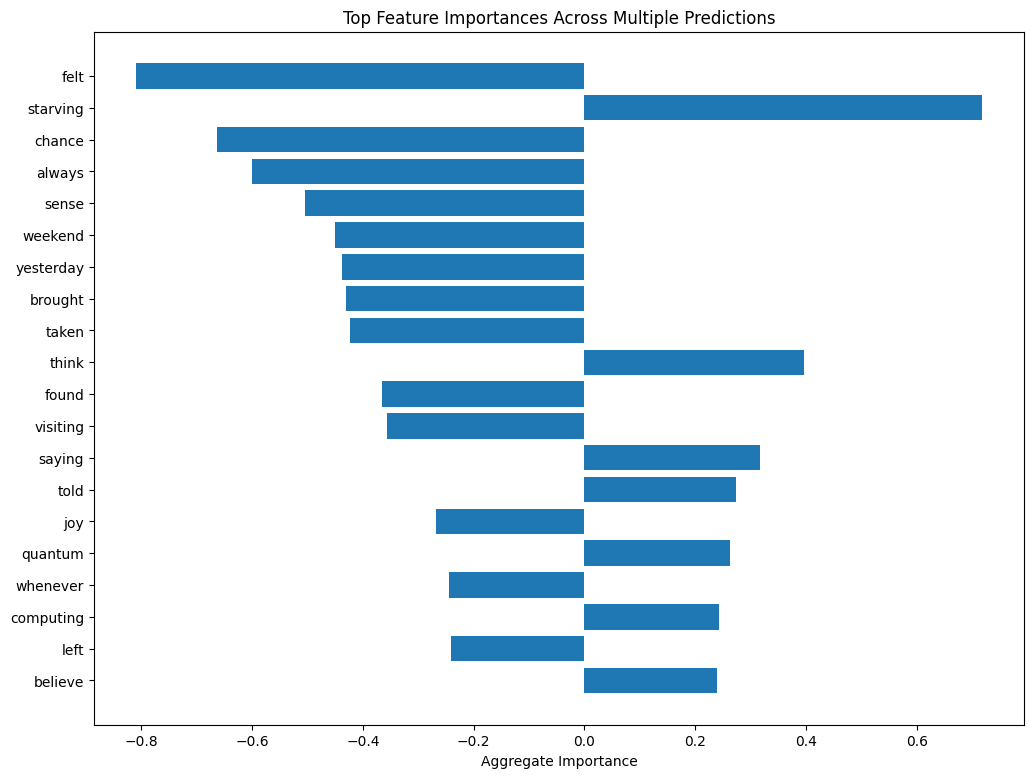

Text: last weekend took moment hiking mountain filled happiness last weekend took moment watching movie felt truly relaxed instance mistaking polite refusal genuine interest serve reminder importance self awareness self advocacy social setting must follow routine participating peer support group network time every day deviation cause great distress sound honking horn trigger range physical symptom headache nausea dizziness fatigue, True label: 0, Predicted label: 1, Confidence: 0.999923050403595
Text: understanding power word pen mightier sword whirlwind kaleidoscope sensation always went cleaning house refreshing experience peculiar people use phrase put egg one basket quite understand metaphor last time choir practice focus conversation due distraction every often made time visiting botanical garden felt sense connection part daily routine fun did project cherished every moment completely absorbed use leitmotif wager opera within classical music metaphor burn bridge never fails make 

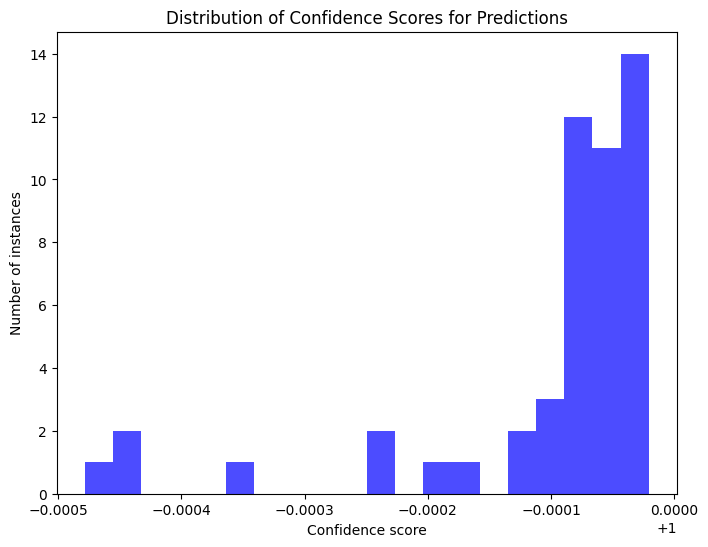

In [8]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

# Define the prediction function for LIME
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=100)
    preds = model.predict(data)
    return np.hstack((1-preds, preds))

# Sample a subset of your data for LIME analysis
sample_texts = [df['processed_note'].iloc[i] for i in range(50)]  # Adjust as needed

# Dictionary for aggregated feature importances
feature_importances = defaultdict(float)

# Lists to store errors and confidence
errors = []
confidence_scores = []

# Analyze model predictions using LIME
for idx, text in enumerate(sample_texts):
    true_label = y_test[idx]
    exp = explainer.explain_instance(text, predict_proba, num_features=10, num_samples=500)  # num_samples can be adjusted
    pred_label = np.argmax(predict_proba([text])[0])
    pred_confidence = predict_proba([text])[0][pred_label]
    # Check if the prediction was incorrect
    if pred_label != true_label:
        errors.append((text, true_label, pred_label, pred_confidence))
    confidence_scores.append(pred_confidence)
    for word, importance in exp.as_list():
        feature_importances[word] += importance

# Sort features by their aggregated importance
sorted_features = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)
top_features = sorted_features[:20]  # Adjust top_n as needed
features, importances = zip(*top_features)

# Visualize the top features based on aggregate importance
plt.figure(figsize=(12, 9))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.gca().invert_yaxis()  # Most important features at the top
plt.xlabel('Aggregate Importance')
plt.title('Top Feature Importances Across Multiple Predictions')
plt.show()

# Print out the errors for further analysis
for error in errors:
    print(f"Text: {error[0]}, True label: {error[1]}, Predicted label: {error[2]}, Confidence: {error[3]}")

# Visualize the distribution of confidence scores
plt.figure(figsize=(8, 6))
plt.hist(confidence_scores, bins=20, alpha=0.7, color='blue')
plt.xlabel('Confidence score')
plt.ylabel('Number of instances')
plt.title('Distribution of Confidence Scores for Predictions')
plt.show()


# Comparing graphs

32/32 [==============================] - 1s 22ms/step


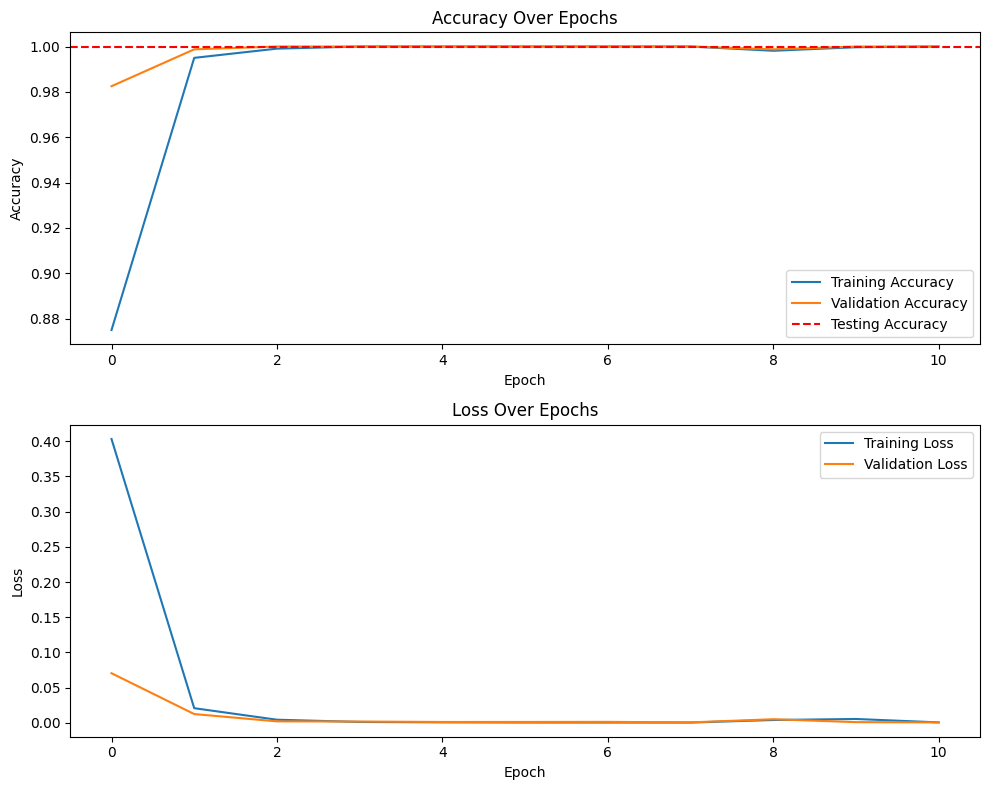

<Figure size 600x600 with 0 Axes>

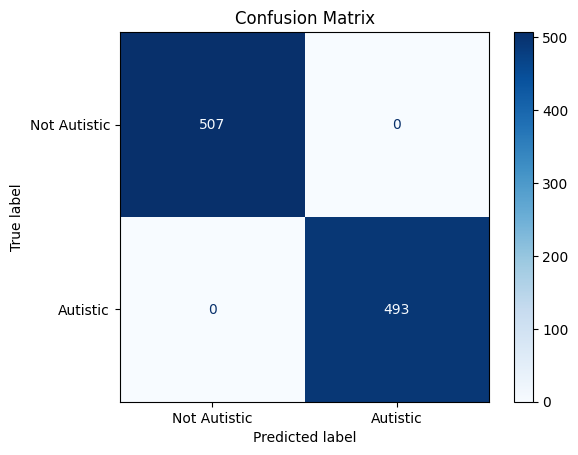

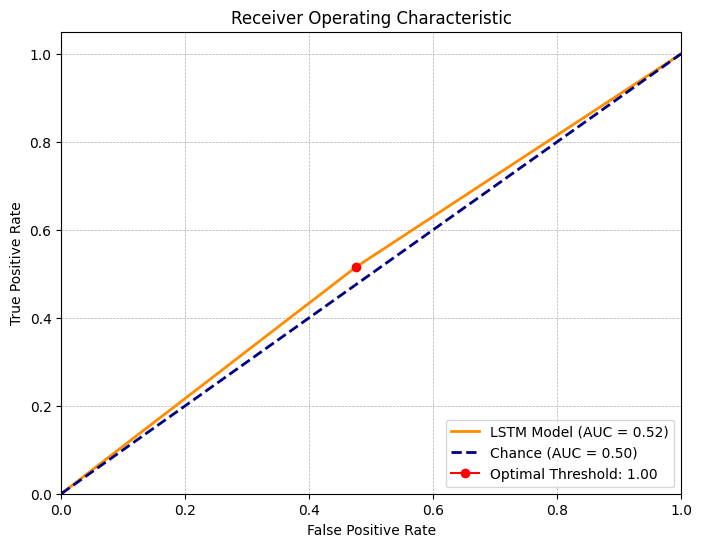

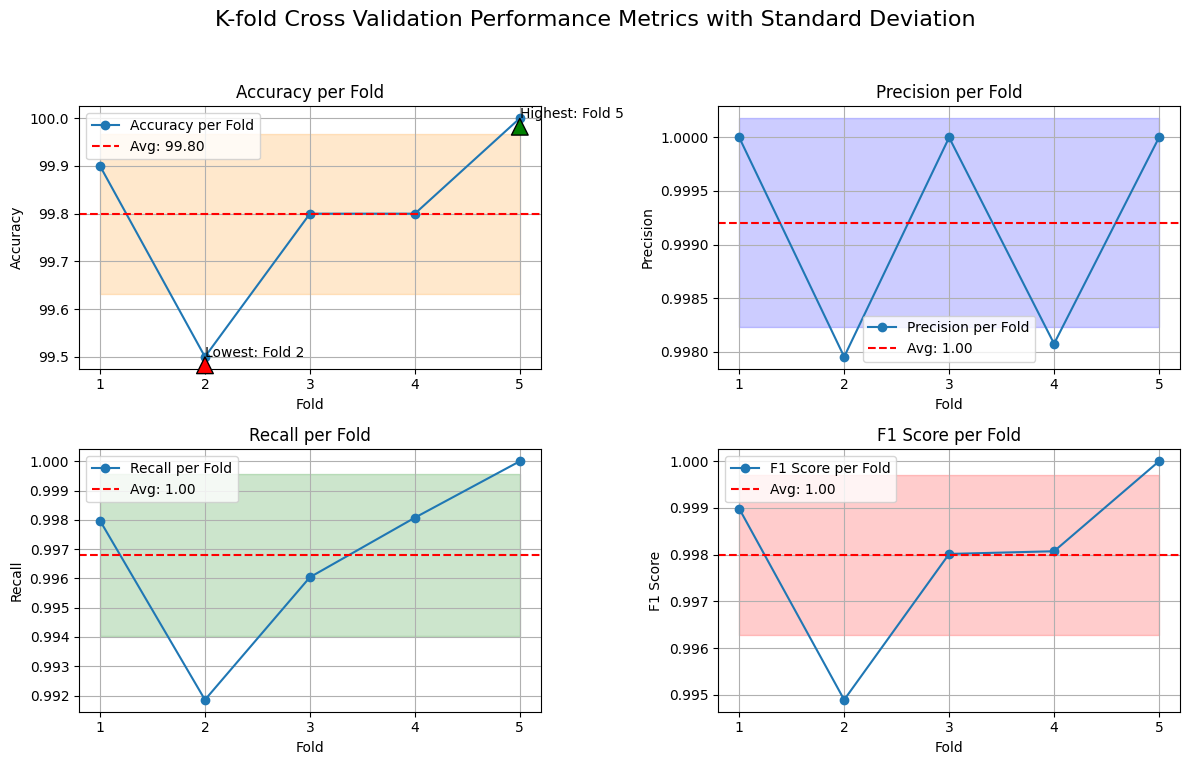

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Ensure predictions are in binary format; this step might be redundant if already done
binary_predictions = [1 if p > 0.5 else 0 for p in model.predict(X_test).flatten()]

# Plotting training, validation, and testing accuracy
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=accuracy, color='r', linestyle='--', label='Testing Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Autistic', 'Autistic'])
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Calculate ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, predictions.flatten())
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='LSTM Model (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold: {:.2f}'.format(optimal_threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# K-fold Cross validation
# Calculating Mean and Standard Deviation across all folds
acc_mean = np.mean(acc_per_fold)
acc_std = np.std(acc_per_fold)

precision_mean = np.mean(precision_per_fold)
precision_std = np.std(precision_per_fold)

recall_mean = np.mean(recall_per_fold)
recall_std = np.std(recall_per_fold)

f1_mean = np.mean(f1_per_fold)
f1_std = np.std(f1_per_fold)

# Plotting along Standard deviation shadows
folds = np.arange(1, num_folds + 1)

plt.figure(figsize=(12, 8))

# Accuracy with standard deviation shadow
plt.subplot(2, 2, 1)
plt.plot(folds, acc_per_fold, '-o', label='Accuracy per Fold')
plt.fill_between(folds, acc_mean - acc_std, acc_mean + acc_std, color='darkorange', alpha=0.2)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold')
plt.xticks(folds)
plt.grid(True)

# Precision with standard deviation shadow
plt.subplot(2, 2, 2)
plt.plot(folds, precision_per_fold, '-o', label='Precision per Fold')
plt.fill_between(folds, precision_mean - precision_std, precision_mean + precision_std, color='blue', alpha=0.2)
plt.xlabel('Fold')
plt.ylabel('Precision')
plt.title('Precision per Fold')
plt.xticks(folds)
plt.grid(True)

# Recall with standard deviation shadow
plt.subplot(2, 2, 3)
plt.plot(folds, recall_per_fold, '-o', label='Recall per Fold')
plt.fill_between(folds, recall_mean - recall_std, recall_mean + recall_std, color='green', alpha=0.2)
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.title('Recall per Fold')
plt.xticks(folds)
plt.grid(True)

# F1 Score with standard deviation shadow
plt.subplot(2, 2, 4)
plt.plot(folds, f1_per_fold, '-o', label='F1 Score per Fold')
plt.fill_between(folds, f1_mean - f1_std, f1_mean + f1_std, color='red', alpha=0.2)
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score per Fold')
plt.xticks(folds)
plt.grid(True)

# Mean Performance Line
for i, metric in enumerate([acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold], 1):
    plt.subplot(2, 2, i)
    mean_value = np.mean(metric)
    plt.axhline(y=mean_value, color='r', linestyle='--', label=f'Avg: {mean_value:.2f}')
    plt.legend()

# Switch to the subplot for accuracy if not already selected
plt.subplot(2, 2, 1)  # Assuming accuracy is plotted in the first subplot

# Add annotations for highest and lowest accuracy
# Assuming acc_per_fold contains accuracy for each fold
max_acc_index = np.argmax(acc_per_fold) + 1  # +1 because fold indexing starts at 1 for human readability
min_acc_index = np.argmin(acc_per_fold) + 1

# Make sure 'acc_std' is defined; if not, you might calculate it as np.std(acc_per_fold)
plt.annotate(f'Highest: Fold {max_acc_index}', 
             xy=(max_acc_index, acc_per_fold[max_acc_index-1]), 
             xytext=(max_acc_index, acc_per_fold[max_acc_index-1]),  # Adjusted for visibility
             arrowprops=dict(facecolor='green', shrink=0.05))

plt.annotate(f'Lowest: Fold {min_acc_index}', 
             xy=(min_acc_index, acc_per_fold[min_acc_index-1]), 
             xytext=(min_acc_index, acc_per_fold[min_acc_index-1]),  # Adjusted for visibility
             arrowprops=dict(facecolor='red', shrink=0.05))


plt.suptitle('K-fold Cross Validation Performance Metrics with Standard Deviation', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Add a central title for the entire figure
plt.suptitle('K-fold Cross Validation Performance Metrics', fontsize=16)

# Adjust layout to make room for the central figure title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()